# Change in exposure to heatwaves

Heat waves are defined here using the index proposed in Jacob et al. [2013] (but using daily minimum temperature data instead of maximum), as any period of more than 3 consecutive days (i.e 4 or more days) exceeding the 99th percentile of the daily minimum temperature of all DJF/JJA seasons for the recent past (1986-2005). The change in heatwave frequency ∆H is the difference between the projected number of heat waves and the number of heat waves in the recent historic period (1986-2005).
  
The heatwave risk Hˆ is then measured as the change in heatwave frequency
∆H multiplied by the population;

$$
H = ∆H(x,t)P(x,t)
$$

where P(x,t) is the population of people aged over 65 at location x at time t.


## Alternative approach: number of days of heatwave

Instead of simply counting the number of periods over the threshold longer than 3 days, why not simply sum the total number of days of 'heatwave condition'. I beleive this to be a much better indicator since it should capture both the number of heatwaves and the change in length of heatwaves. With the previous method, a 3-week heatwave counts the same as a 4 days one.


The heatwave indicator is therefor in units of 'Days of heatwave conditions'.

The heatwave exposure indicator is in days-person exposed - which can be thought of as the total number of days of heatwave experienced (e.g. 2 people experiencing the same day of heatwave, a total of 2 days of heatwaves have been experienced)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


from scipy import stats
from numba import jit
from tqdm import tnrange, tqdm_notebook

import population_tools
from config import DATA_SRC, POP_DATA_SRC

import matplotlib as mpl
mpl.rc('figure', titlesize=12)

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [3]:
t_min_file = DATA_SRC / 'weather' / 'ecmwf' / 'era_interim_temperature_day_min.nc'
high_t_reference_file = DATA_SRC / 'lancet' / 'heatwave_high_t_reference.nc'

## Adjust by population over 65

- Use the proportion in 2005 and assume that this does not change significantly in the period of interest from 2000-2015

In [7]:
UN_DEMOGRAPHICS_TABLE = pd.read_csv(POP_DATA_SRC / 'UN' / 'WPP2015_INT_F2B_Annual_Population_Indicators_Percentage.csv')

country_shapefile = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

# COUNTRY_POLY_SHP
COUNTRIES = gpd.read_file(str(country_shapefile))
# Translate to match raster coordinates
COUNTRIES.geometry = COUNTRIES.translate(xoff=180)

# Remove missing UN A3 code fields, convert to int and set as index
COUNTRIES.loc[COUNTRIES.un_a3 == '-099', 'un_a3'] = np.nan
COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(float)
COUNTRIES = COUNTRIES[np.isfinite(COUNTRIES.un_a3)]
COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(int)
COUNTRIES = COUNTRIES.set_index('un_a3')



In [4]:
def get_country_demographics_for_year(year):
    un_demographics = UN_DEMOGRAPHICS_TABLE.set_index('LocID')
    un_demographics = un_demographics[un_demographics.Variant == 'Medium']
    un_demographics = un_demographics[un_demographics.Time == year]
    return COUNTRIES.join(un_demographics['pPopTot_65_100'])

## Rasterize the population over 65 by country onto the population grid

In [31]:
pct_age_rasters = []
with population_tools.PopulationProjector() as pop:
    for year in tnrange(2000, 2017):
        countries = get_country_demographics_for_year(year)
        raster = pop.rasterize_data(countries, 'pPopTot_65_100')
        raster*= pop.water_mask.squeeze()
        raster /= 100
        raster.shape = (*raster.shape, 1)
        pct_age_rasters.append(xr.DataArray(raster, 
                                        coords=[pop.data.latitude, pop.data.longitude, [year]], 
                                        dims=['latitude', 'longitude', 'year'], name='pop_over_65'))
        
pct_age_rasters = xr.concat(pct_age_rasters, dim='year')

In [29]:
pct_age_rasters.to_netcdf(str(DATA_SRC / 'lancet' / 'population_over_65.nc'))

In [2]:
pct_age_rasters = xr.open_dataarray(str(DATA_SRC / 'lancet' / 'population_over_65.nc'))

In [5]:
pct_age_rasters

<xarray.DataArray 'pop_over_65' (latitude: 2175, longitude: 5400, year: 17)>
[199665000 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float64 85.0 84.93 84.87 84.8 84.73 84.67 84.6 ...
  * longitude  (longitude) float64 0.0 0.06667 0.1333 0.2 0.2667 0.3333 0.4 ...
  * year       (year) int64 2000 2001 2002 2003 2004 2005 2006 2007 2008 ...

## Load weather data and save minimas

NOTE: only need to do this once

In [ ]:
# weather_file = DATA_SRC / 'weather' / 'ecmwf' / 'era_interim_temperature_2m.nc'
# era_alltemps = xr.open_dataset(str(weather_file), chunks={'time': 24})
# era_allmin = era_alltemps.resample('1D', dim='time', how='min')
# era_allmin.to_netcdf(str(t_min_file))

### Open the saved minimas file

In [4]:
era_allmin = xr.open_dataset(str(t_min_file), chunks={'time': 365})
temperatures = era_allmin.t2m
# era_allmin = xr.open_dataset(str(t_min_file))

## Calculate the 99th percentile 1986-2005

Only need to do this once, afterwards load the saved file

In [7]:
# recent_past = era_allmin.sel(time=slice('1986-01-01', '2005-12-31'))
# high_t_reference = recent_past.quantile(0.99, dim='time')
# high_t_reference.to_netcdf(str(high_t_reference_file))

### Load the high-t reference file

In [5]:
high_t_reference = xr.open_dataset(str(high_t_reference_file))
high_t_reference = high_t_reference.t2m.load()

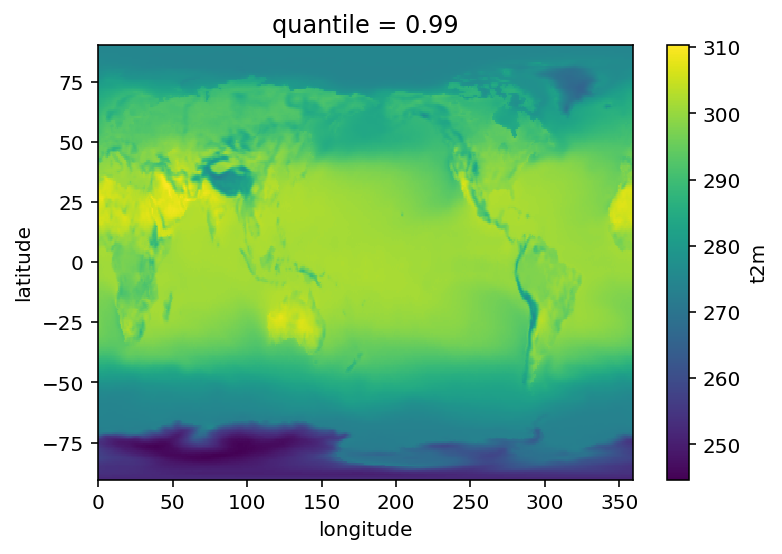

In [97]:
high_t_reference.plot()

## For period of interest, select where t > tref

In [6]:
@jit("int64[:,:](b1[:,:,:])")
def fast_heatwaves_lengths(dataset_year_asbool):
    
    last_slice = None
    accumulator = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    lengther = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    
    for i in range(1, dataset_year_asbool.shape[0]):
        last_slice = dataset_year_asbool[i-1, :, :]
        data_slice = dataset_year_asbool[i, :, :]

        # Add to the sequence length counter at all positions
        # above threshold at prev time step
        accumulator[last_slice] += 1
        
        # End of sequence is where prev is true and current is false
        # True where prev and not current
        mask = last_slice & np.logical_not(data_slice)
        
        # Add the length of the accumulator where the sequences are ending and are > 3
        # TODO should the length include the first 3 days?
        lengther[mask & (accumulator > 3)] += accumulator[mask & (accumulator > 3)]
        # Reset the accumulator where current slice is empty
        accumulator[np.logical_not(data_slice)] = 0
            
    return lengther

@jit("int64[:,:](b1[:,:,:])")
def fast_heatwaves_counts(dataset_year_asbool):
    
    last_slice = None
    accumulator = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    counter = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    
    for i in range(1, dataset_year_asbool.shape[0]):
        last_slice = dataset_year_asbool[i-1, :, :]
        data_slice = dataset_year_asbool[i, :, :]

        # Add to the sequence length counter at all positions
        # above threshold at prev time step
        accumulator[last_slice] += 1
        
        # End of sequence is where prev is true and current is false
        # True where prev and not current
        mask = last_slice & np.logical_not(data_slice)
        
        # Add one the the counter where the sequences are ending AND > 3
        counter[mask & (accumulator > 3)] += 1
        # Reset the accumulator where current slice is empty
        accumulator[np.logical_not(data_slice)] = 0
            
    return counter


def get_summer_temperatures(year, temperatures):
    t_yr = temperatures.sel(time=f'{year}')
    lat_north = temperatures.latitude[temperatures.latitude >= 0]
    lat_south = temperatures.latitude[temperatures.latitude < 0]
    
    tnh = t_yr.sel(latitude=lat_north)
    tnh = tnh.where(t_yr['time.season'] == 'JJA')

    tsh = t_yr.sel(latitude=lat_south)
    tsh = tsh.where(t_yr['time.season'] == 'DJF')

    
    t_yr = xr.concat([tnh, tsh], 
                     dim='latitude')
    t_yr = t_yr.fillna(-9999)
    return t_yr


def heatwave_length_for_year(year, temperatures, reference):
    dataset_year = get_summer_temperatures(year, temperatures)
    
    dataset_year_asbool = xr.ufuncs.isfinite(dataset_year.where(dataset_year > reference)).values
    
    counter = fast_heatwaves_lengths(dataset_year_asbool)

    counter.shape = (*counter.shape, 1)
    counter = xr.DataArray(counter, 
                            coords=[dataset_year.latitude.values,
                                    dataset_year.longitude.values,
                                    [year]
                                   ], 
                           dims=['latitude', 'longitude', 'year'],
                           name='heatwave_count'
                          )
    
    return counter


def heatwave_count_for_year(year, temperatures, reference):
    dataset_year = get_summer_temperatures(year, temperatures)
    
    dataset_year_asbool = xr.ufuncs.isfinite(dataset_year.where(dataset_year > reference)).values
    
    counter = fast_heatwaves_counts(dataset_year_asbool)

    counter.shape = (*counter.shape, 1)
    counter = xr.DataArray(counter, 
                            coords=[dataset_year.latitude.values,
                                    dataset_year.longitude.values,
                                    [year]
                                   ], 
                           dims=['latitude', 'longitude', 'year'],
                           name='heatwave_count'
                          )
    
    return counter    

In [7]:
def _gen():
    for year in tnrange(1986, 2017):
        yield heatwave_count_for_year(year, temperatures, high_t_reference)

heatwaves_counts = xr.concat(_gen(), dim='year').astype(float)


In [8]:
def _gen():
    for year in tnrange(1986, 2017):
        yield heatwave_length_for_year(year, temperatures, high_t_reference)

heatwaves_lengths = xr.concat(_gen(), dim='year').astype(float)

In [9]:
heatwaves_counts.to_netcdf(str(DATA_SRC / 'lancet'/'heatwaves_counts_all_years.nc'))
heatwaves_lengths.to_netcdf(str(DATA_SRC / 'lancet'/'heatwaves_lengths_all_years.nc'))

### Open saved results

In [15]:
heatwaves_counts = xr.open_dataarray(str(DATA_SRC / 'lancet'/'heatwaves_counts_all_years.nc'))
heatwaves_lengths = xr.open_dataarray(str(DATA_SRC / 'lancet'/'heatwaves_lengths_all_years.nc'))

### Calculate historical and delta
### Get the area-weighted time series for counts and lengths

In [16]:
# Take average period to match Temperature Change calculations
heatwaves_counts_historical = heatwaves_counts.sel(year=slice(1986,2008)).mean(dim='year')
heatwaves_counts_delta = heatwaves_counts.sel(year=slice(2000,2017)) - heatwaves_counts_historical

In [17]:
heatwaves_lengths_historical = heatwaves_lengths.sel(year=slice(1986,2008)).mean(dim='year')
heatwaves_lengths_delta = heatwaves_lengths.sel(year=slice(2000,2017)) - heatwaves_lengths_historical

In [18]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(heatwaves_lengths.latitude))
heatwaves_counts_ts = (heatwaves_counts_delta * cos_lat).mean(dim=['latitude', 'longitude'])
heatwaves_lengths_ts = (heatwaves_lengths_delta * cos_lat).mean(dim=['latitude', 'longitude'])


## Heatwave count plots

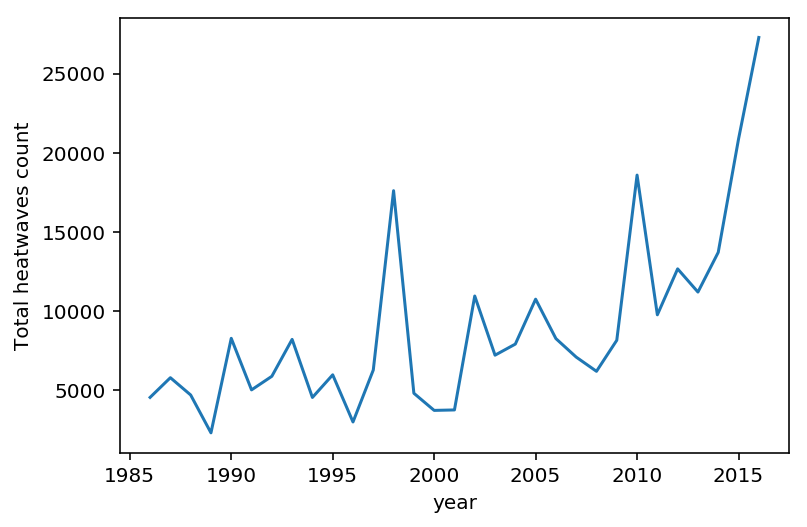

In [13]:
heatwaves_counts.sum(dim=['latitude', 'longitude']).plot()
plt.ylabel('Total heatwaves count')
plt.savefig('total_heatwaves_count.png')

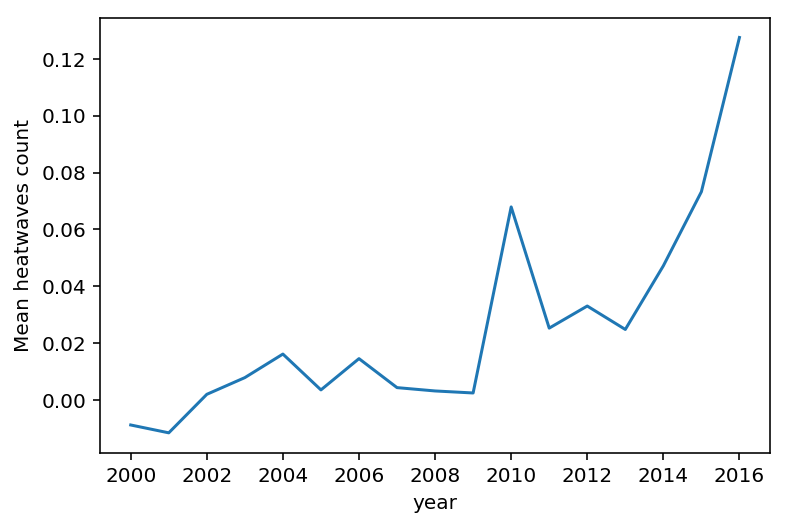

In [14]:
heatwaves_counts_ts.plot()
plt.ylabel('Mean heatwaves count')
plt.savefig('change_mean_heatwaves_count.png')

In [48]:
# year_data = heatwaves_counts.sel(year=2000)

# f = plt.figure(figsize=(6,3))

# ax = plt.axes(projection=ccrs.PlateCarree())
# year_data.plot.pcolormesh(ax=ax,
#                           transform=ccrs.PlateCarree(),
#                           cbar_kwargs=dict(label='N heatwaves'))
# ax.coastlines()
# plt.tight_layout()
# f.savefig('heatwave_count_2000.png')

# year_data = heatwaves_counts.sel(year=2015)

# f = plt.figure(figsize=(6,3))

# ax = plt.axes(projection=ccrs.PlateCarree())
# year_data.plot.pcolormesh(ax=ax,
#                           transform=ccrs.PlateCarree(),
#                           cbar_kwargs=dict(label='N heatwaves'))
# ax.coastlines()
# plt.tight_layout()
# f.savefig('heatwave_count_2015.png') 

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


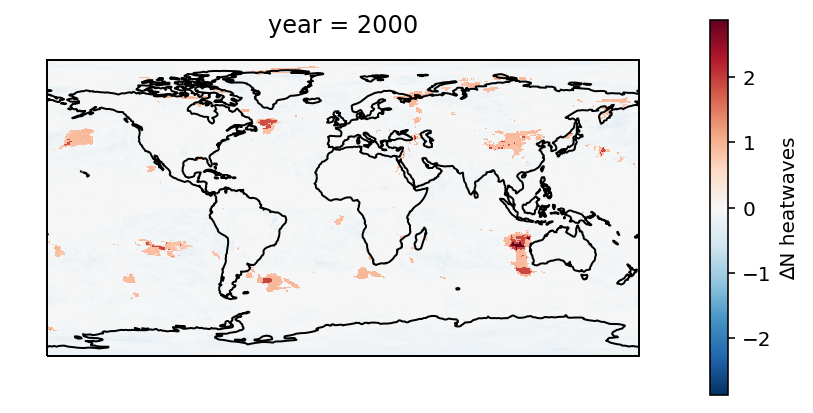

In [25]:
year_data = heatwaves_counts_delta.sel(year=2000)

f = plt.figure(figsize=(6,3))

ax = plt.axes(projection=ccrs.PlateCarree())
year_data.plot.pcolormesh(ax=ax,
                          transform=ccrs.PlateCarree(),
                          cbar_kwargs=dict(label='∆N heatwaves'))
ax.coastlines()
plt.tight_layout()
f.savefig('heatwave_count_delta_2000.png')

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


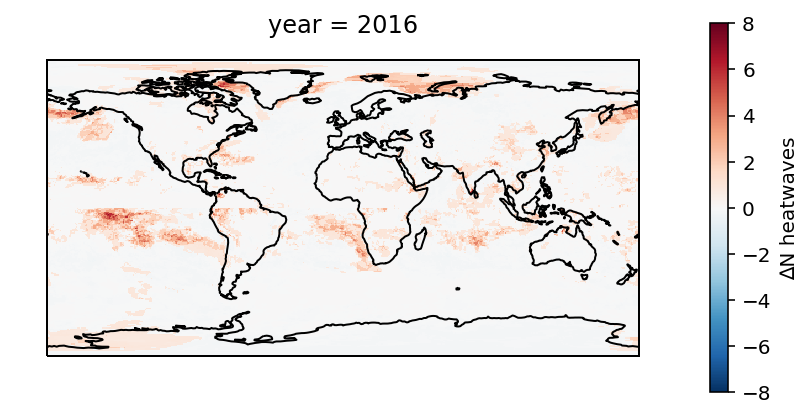

In [15]:
year_data = heatwaves_counts_delta.sel(year=2016)

f = plt.figure(figsize=(6,3))

ax = plt.axes(projection=ccrs.PlateCarree())
year_data.plot.pcolormesh(ax=ax,
                          transform=ccrs.PlateCarree(),
                          cbar_kwargs=dict(label='∆N heatwaves'))
ax.coastlines()
plt.tight_layout()
f.savefig('heatwave_count_delta_2016.png')

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


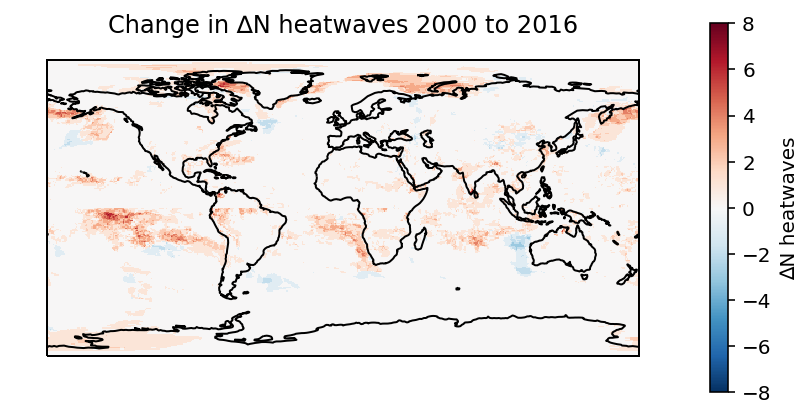

In [16]:
year_data = heatwaves_counts_delta.sel(year=2016) - heatwaves_counts_delta.sel(year=2000)

f = plt.figure(figsize=(6,3))

ax = plt.axes(projection=ccrs.PlateCarree())
year_data.plot.pcolormesh(ax=ax,
                          transform=ccrs.PlateCarree(),
                          cbar_kwargs=dict(label='∆N heatwaves'))
ax.coastlines()

plt.title('Change in ∆N heatwaves 2000 to 2016')
plt.tight_layout()
f.savefig('heatwave_count_delta_change_2000-2016.png')

## Heatwave length plots

In [58]:
# heatwaves_lengths.sum(dim=['latitude', 'longitude']).plot()
# plt.ylabel('Total heatwaves days')
# plt.savefig('total_heatwaves_length.png')

In [59]:
# heatwaves_lengths_ts.plot()
# plt.ylabel('Mean heatwave days')
# plt.savefig('mean_heatwaves_length.png')

In [60]:
# heatwaves_lengths_delta.sel(year=slice(2000, 2016)).sum(dim=['latitude', 'longitude']).plot()
# plt.ylabel('Total change in heatwave days')
# plt.savefig('change_total_heatwaves_length.png', , bbox_inches='tight')

In [61]:
# heatwaves_lengths_delta.sel(year=slice(2000, 2016)).mean(dim=['latitude', 'longitude']).plot()
# plt.ylabel('Mean change in heatwave days')
# plt.savefig('change_mean_heatwaves_length.png')

In [47]:
# year_data = heatwaves_lengths.sel(year=2000)

# f = plt.figure(figsize=(6,3))

# ax = plt.axes(projection=ccrs.PlateCarree())
# year_data.plot.pcolormesh(ax=ax,
#                           transform=ccrs.PlateCarree(),
#                           cbar_kwargs=dict(label='heatwaves length (days)'))
# ax.coastlines()
# plt.tight_layout()
# f.savefig('heatwave_length_2000.png')

# year_data = heatwaves_lengths.sel(year=2015)

# f = plt.figure(figsize=(6,3))

# ax = plt.axes(projection=ccrs.PlateCarree())
# year_data.plot.pcolormesh(ax=ax,
#                           transform=ccrs.PlateCarree(),
#                           cbar_kwargs=dict(label='heatwaves length (days)'))
# ax.coastlines()
# plt.tight_layout()
# f.savefig('heatwave_length_2015.png')

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


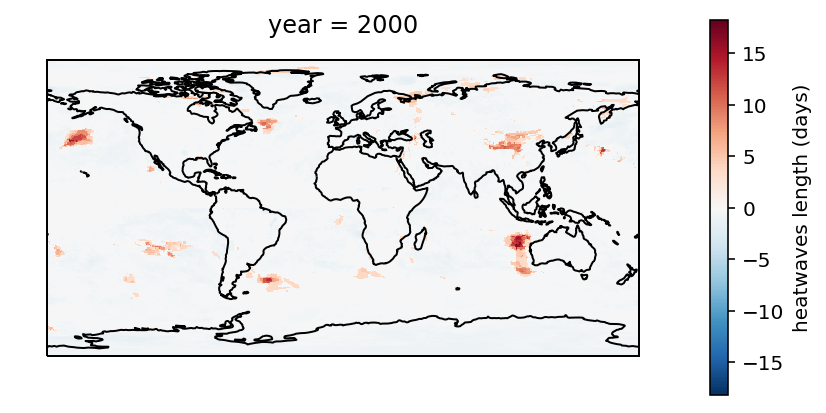

In [22]:
year_data = heatwaves_lengths_delta.sel(year=2000)

f = plt.figure(figsize=(6,3))

ax = plt.axes(projection=ccrs.PlateCarree())
year_data.plot.pcolormesh(ax=ax,
                          transform=ccrs.PlateCarree(),
                          cbar_kwargs=dict(label='heatwaves length (days)'))
ax.coastlines()
plt.tight_layout()
f.savefig('heatwave_length_delta_2000.png')

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


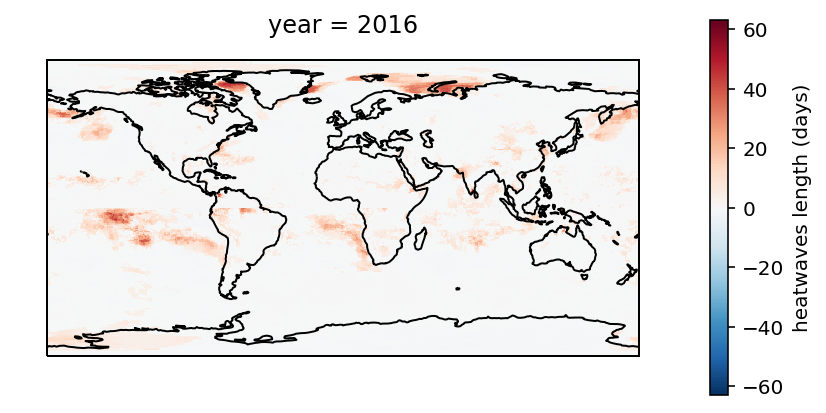

In [23]:
year_data = heatwaves_lengths_delta.sel(year=2016)

f = plt.figure(figsize=(6,3))

ax = plt.axes(projection=ccrs.PlateCarree())
year_data.plot.pcolormesh(ax=ax,
                          transform=ccrs.PlateCarree(),
                          cbar_kwargs=dict(label='heatwaves length (days)'))
ax.coastlines()
plt.tight_layout()
f.savefig('heatwave_length_delta_2016.png')

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


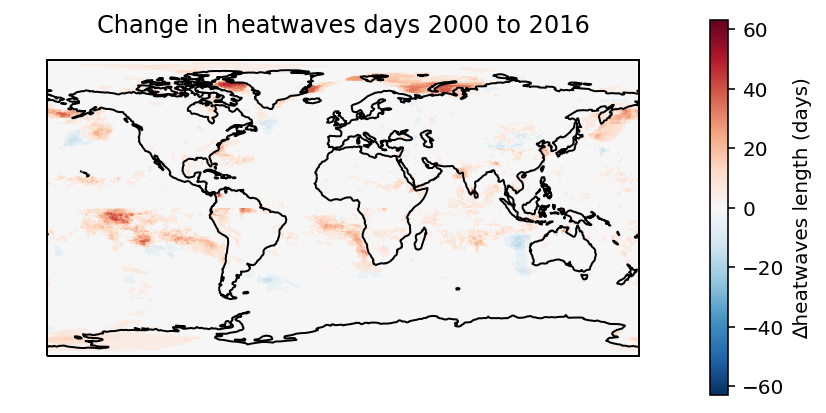

In [62]:
year_data = heatwaves_lengths_delta.sel(year=2016) - heatwaves_lengths_delta.sel(year=2000)

f = plt.figure(figsize=(6,3))

ax = plt.axes(projection=ccrs.PlateCarree())
year_data.plot.pcolormesh(ax=ax,
                          transform=ccrs.PlateCarree(),
                          cbar_kwargs=dict(label='∆heatwaves length (days)'))
ax.coastlines()

plt.title('Change in heatwaves days 2000 to 2016')
plt.tight_layout()
f.savefig('heatwave_length_delta_change_2000-2016.png')

## Project the heatwave change onto the population

In [8]:
def project_heatwaves(heatwaves_delta):
    with population_tools.PopulationProjector() as pop:
        pop_sum = (pop.data * pct_age_rasters).sum(dim=['latitude', 'longitude'])
        
        def _gen():
            for year in tnrange(2000, 2017):
                yield (pop.project(year, heatwaves_delta.sel(year=year)) * pct_age_rasters.sel(year=year))
        heatwaves_pop = xr.concat(_gen(), dim='year')
        heatwaves_pop_ts = (heatwaves_pop / pop_sum).sum(dim=['latitude', 'longitude']).compute()
    return heatwaves_pop_ts
#     return heatwaves_pop




## Plot the heatwave counts area mean against the population weighted mean

In [9]:
# heatwaves_c_pop_ts = project_heatwaves(heatwaves_counts_delta, pop_sum.sel(year=slice(2000,2017)))
heatwaves_c_pop_ts = project_heatwaves(heatwaves_counts_delta)


/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:476: RuntimeWarning: overflow encountered in true_divide
  o = func(*args, **kwargs)
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:2544: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)


In [12]:
heatwaves_c_pop_ts.to_netcdf(str(DATA_SRC / 'lancet' / 'heatwave_c_change_pop.nc'))

In [5]:
heatwaves_c_pop_ts = xr.open_dataarray(str(DATA_SRC / 'lancet' / 'heatwave_c_change_pop.nc'))

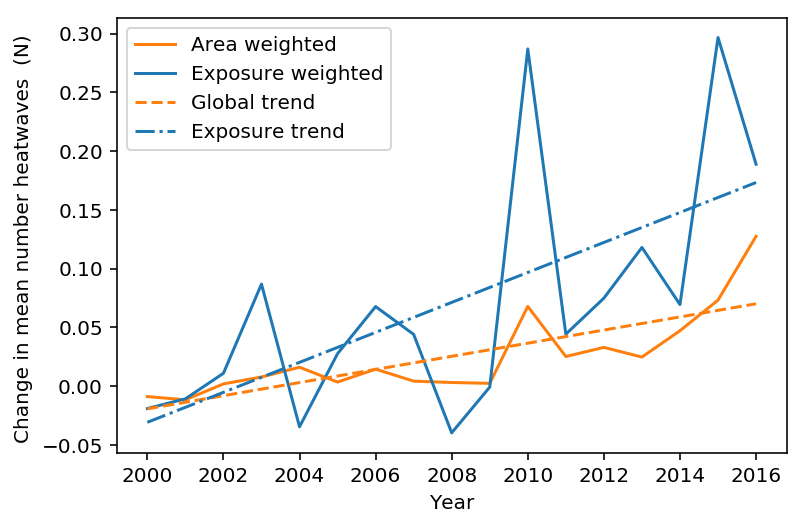

In [69]:
heatwaves_counts_ts.plot(color='C1',label='Area weighted')
heatwaves_c_pop_ts.plot(color='C0',label='Exposure weighted')


anom_reg = stats.linregress(heatwaves_counts_ts.year.values, heatwaves_counts_ts.values)
anom_reg = (anom_reg.slope * heatwaves_counts_ts.year) + anom_reg.intercept

exposures_reg = stats.linregress(heatwaves_c_pop_ts.year.values, heatwaves_c_pop_ts.values)
exposures_reg = (exposures_reg.slope * heatwaves_c_pop_ts.year) + exposures_reg.intercept

anom_reg.plot.line('--', color='C1', label='Global trend')
exposures_reg.plot.line('-.', color='C0', label='Exposure trend')


plt.xlabel('Year')
plt.ylabel('Change in mean number heatwaves  (N) ')
plt.legend()
plt.savefig('heatwaves_count_comp_2000-2016.png', dpi=300, bbox_inches='tight')




## Plot the heatwaves lengths area mean against population weighted mean

In [13]:
heatwaves_l_pop_ts = project_heatwaves(heatwaves_lengths_delta)



/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:476: RuntimeWarning: overflow encountered in true_divide
  o = func(*args, **kwargs)
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:2544: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)


In [14]:
heatwaves_l_pop_ts.to_netcdf(str(DATA_SRC / 'lancet' / 'heatwave_l_change_pop.nc'))

In [12]:
heatwaves_l_pop_ts = xr.open_dataarray(str(DATA_SRC / 'lancet' / 'heatwave_l_change_pop.nc'))

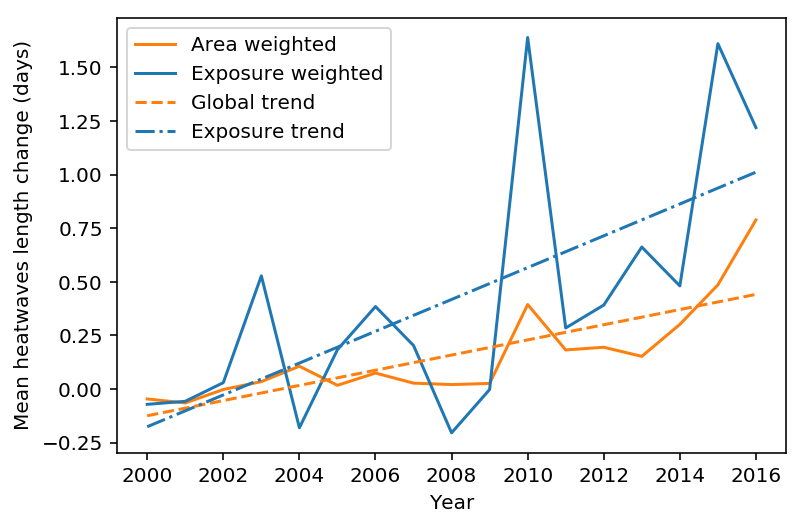

In [67]:
heatwaves_lengths_ts.plot(color='C1',label='Area weighted')
heatwaves_l_pop_ts.plot(color='C0',label='Exposure weighted')


anom_reg = stats.linregress(heatwaves_lengths_ts.year.values, heatwaves_lengths_ts.values)
anom_reg = (anom_reg.slope * heatwaves_lengths_ts.year) + anom_reg.intercept

exposures_reg = stats.linregress(heatwaves_l_pop_ts.year.values, heatwaves_l_pop_ts.values)
exposures_reg = (exposures_reg.slope * heatwaves_l_pop_ts.year) + exposures_reg.intercept

anom_reg.plot.line('--', color='C1', label='Global trend')
exposures_reg.plot.line('-.', color='C0', label='Exposure trend')


plt.xlabel('Year')
plt.ylabel('Mean heatwaves length change (days)')
plt.legend()
plt.savefig('heatwaves_length_comp_2000-2016.png', dpi=300, bbox_inches='tight')


In [20]:
heatwaves_counts_ts.name = 'heatwave_counts'
heatwaves_c_pop_ts.name = 'heatwave_counts_pop'

heatwaves_lengths_ts.name = 'heatwave_lengths'
heatwaves_l_pop_ts.name = 'heatwave_lengths_pop'

writer = pd.ExcelWriter(str(DATA_SRC / 'lancet' / 'heatwave_exposure.xlsx'))


output = heatwaves_counts_ts.to_dataframe().join(heatwaves_c_pop_ts.to_dataframe())
output.columns = ['Area weighted change N count', 'Exposure weighted change mean N count']

output.to_excel(writer, sheet_name='heatwaves_counts')

output = heatwaves_lengths_ts.to_dataframe().join(heatwaves_l_pop_ts.to_dataframe())
output.columns = ['Area weighted change (days)', 'Exposure weighted change (days)']

output.to_excel(writer, sheet_name='heatwaves_lengths')

writer.save()


## Plots based on Watts et. al 2015 method

This approach normalized per-population density per-unit-area. However the updated method normalises only by population. Note that this makes more sense, especially since taking the of sum of per-unit-area values is a bit wierd.

In [26]:
def project_heatwaves_exposures(heatwaves_delta):
    with population_tools.PopulationProjector(population_tools.PopulationType.count.value) as pop:        
        def _gen():
            for year in tnrange(2000, 2017):
                yield (pop.project(year, heatwaves_delta.sel(year=year)) * pct_age_rasters.sel(year=year))
        heatwaves_pop = xr.concat(_gen(), dim='year')
        
        
        heatwaves_pop = xr.concat(heatwaves_pop, dim='year')
        heatwaves_pop_ts = heatwaves_pop.sum(dim=['latitude', 'longitude']).compute()
    return heatwaves_pop_ts



In [ ]:
heatwaves_pop_events_ts = project_heatwaves_exposures(heatwaves_counts_delta)

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


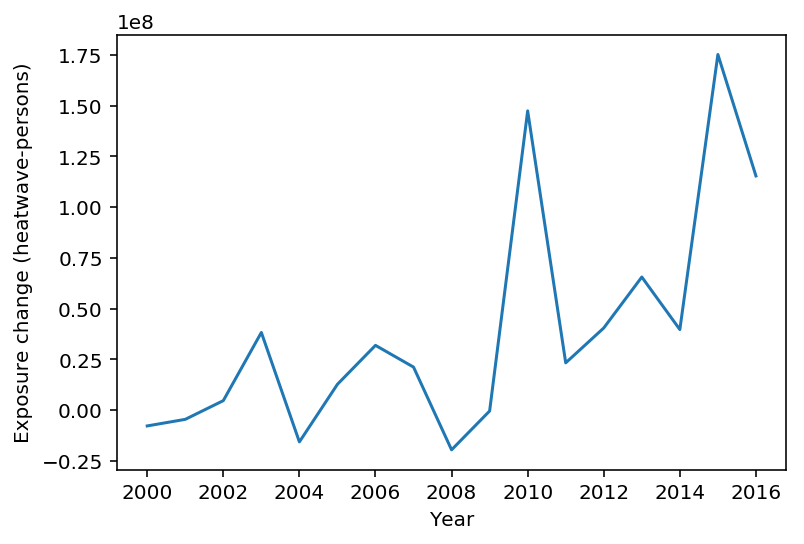

In [44]:
heatwaves_pop_events_ts.plot()


plt.xlabel('Year')
plt.ylabel('Exposure change (heatwave-persons)')
plt.legend()
plt.savefig('heatwaves_n_exposure_2000-2016.png', dpi=300, bbox_inches='tight')



In [27]:
heatwaves_pop_events_days_ts = project_heatwaves_exposures(heatwaves_lengths_delta)

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:2544: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)


/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


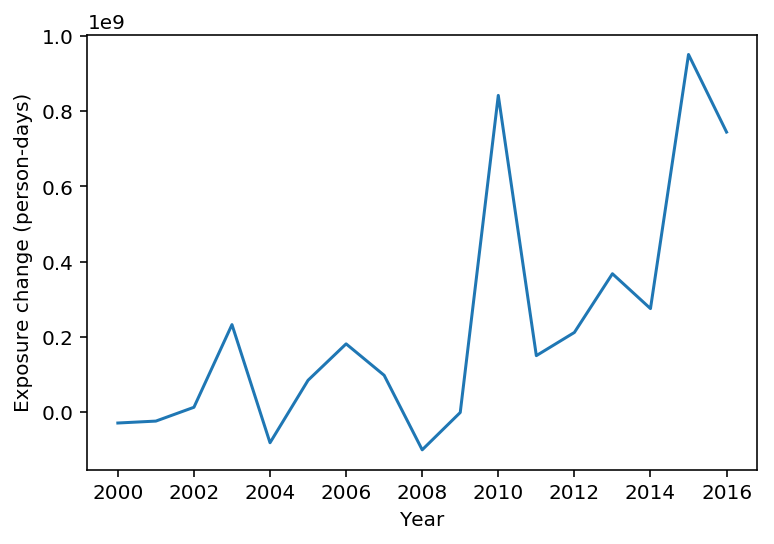

In [45]:
heatwaves_pop_events_days_ts.plot()


plt.xlabel('Year')
plt.ylabel('Exposure change (person-days)')
plt.legend()
plt.savefig('heatwaves_days_exposure_2000-2016.png', dpi=300, bbox_inches='tight')




## Calculate the number of people affected by at least one heatwave each year

In [49]:
def count_people_exposed(heatwaves_delta):
    with population_tools.PopulationProjector(population_tools.PopulationType.count.value) as pop:
        hw = xr.ufuncs.isfinite(heatwaves_delta.where(heatwaves_delta >0)).astype(float)
        def _gen():
            for year in tnrange(2000, 2017):
                yield (pop.project(year, hw.sel(year=year)) * pct_age_rasters.sel(year=year))
        heatwaves_pop = xr.concat(_gen(), dim='year')
        
        
        heatwaves_pop = xr.concat(heatwaves_pop, dim='year')
        heatwaves_pop_ts = heatwaves_pop.sum(dim=['latitude', 'longitude']).compute()
    return heatwaves_pop_ts




In [50]:
people_affected = count_people_exposed(heatwaves_counts)

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:2544: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)


/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


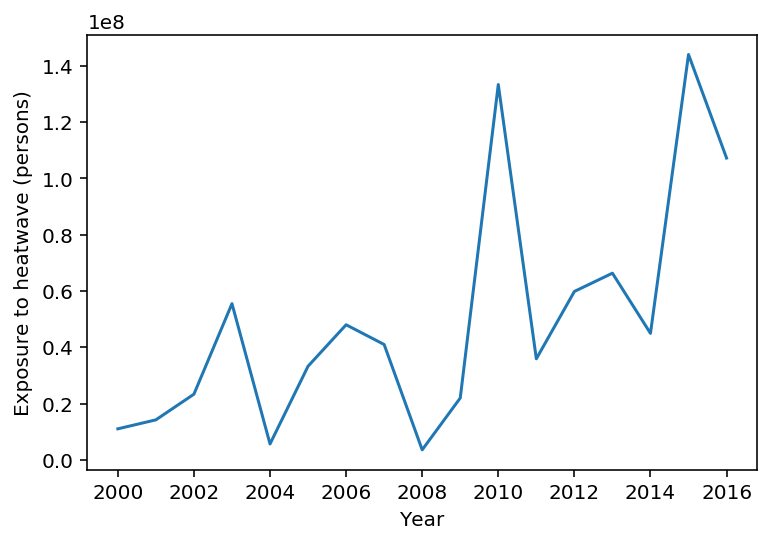

In [57]:
people_affected.plot()


plt.xlabel('Year')
plt.ylabel('Exposure to heatwave (persons)')
plt.legend()
plt.savefig('heatwaves_n_people_affected_2000-2016.png', dpi=300, bbox_inches='tight')


